<a href="https://colab.research.google.com/github/shaswata09/Offroad-Path-Planning/blob/main/Road_Extractor_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U albumentations

!pip install --upgrade opencv-python

!pip install segmentation-models-pytorch==0.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 5.2 MB/s 
     |████████████████████████████████| 58 kB 8.1 MB/s 
     |████████████████████████████████| 376 kB 56.7 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=edf6863cbb7ec7c0f39f7cbdaa35415d115f77f371aad226a28513cbee1cc62d
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=8dfa45dc04e59ead871545e08bd05da29b2544e3660b4de4e5e688419a0f7aed
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96

In [ ]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

import segmentation_models_pytorch as smp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
DATA_DIR = './massachusetts-roads-dataset/tiff/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')
print(x_train_dir)
print(y_train_dir)

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')
print(x_valid_dir)
print(y_valid_dir)

x_test_dir = os.path.join(DATA_DIR, 'custom_offroad_testset')
# x_test_dir = os.path.join(DATA_DIR, 'cavs_offroad_dataset')
# x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')
print(x_test_dir)
print(y_test_dir)

./massachusetts-roads-dataset/tiff/train
./massachusetts-roads-dataset/tiff/train_labels
./massachusetts-roads-dataset/tiff/val
./massachusetts-roads-dataset/tiff/val_labels
./massachusetts-roads-dataset/tiff/custom_offroad_testset
./massachusetts-roads-dataset/tiff/test_labels


In [ ]:
class_dict = pd.read_csv("./massachusetts-roads-dataset/label_class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'road']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [ ]:
select_classes = ['background', 'road']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', select_classes)
print('Class RGB values: ', select_class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'road']
Class RGB values:  [[  0   0   0]
 [255 255 255]]


In [ ]:
from numpy.ma.core import shape
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        # print(shape(label))
        # print(colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    # print(shape(semantic_map))
    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    # print(shape(x))
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]
    # print(image.astype(int))
    # print(shape(x))

    return x

In [ ]:
class RoadsDataset(torch.utils.data.Dataset):

    """Massachusetts Roads Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        # self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        ## HSV color conversion can be helpful
        ## image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2HSV)
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        # mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        # mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        # print(mask[0])

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image)
            image = sample['image']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image)
            image = sample['image']
            
        return image
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

In [ ]:
def get_training_augmentation():
    train_transform = [    
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

In [ ]:
# https://github.com/qubvel/segmentation_models.pytorch#encoders
# Test with the other models in the above link
####################################
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model_deepLab = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

model_unet = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# load best saved Unet model checkpoint from the current run
if os.path.exists('./best_model_unet_softmax_deepglobe.pth'):
    best_model_unet = torch.load('./best_model_unet_softmax_deepglobe.pth', map_location=DEVICE)
    print('Loaded UNet model from this run.')

else:
  print('Error!!! Unable to load model from drive.')

Loaded UNet model from this run.


In [ ]:
# load best saved DeepLab model checkpoint from the current run
if os.path.exists('./best_model_DeepLab_softmax_deepglobe.pth'):
    best_model_deepLab = torch.load('./best_model_DeepLab_softmax_deepglobe.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')

else:
  print('Error!!! Unable to load model from drive.')

Loaded DeepLabV3+ model from this run.


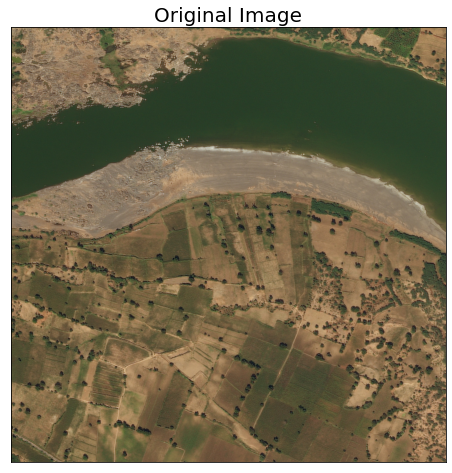

In [ ]:
# create test dataloader to be used with UNet model (with preprocessing operation: to_tensor(...))
test_dataset = RoadsDataset(
    x_test_dir, 
    x_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = RoadsDataset(
    x_test_dir, x_test_dir, 
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)

# image, mask = test_dataset_vis[random_idx]
image = test_dataset_vis[2]
# image = test_dataset[2]
# image = cv2.resize(image, (1500, 1500), interpolation = cv2.INTER_AREA)


visualize(
    original_image = image,
    # ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    # one_hot_encoded_mask = reverse_one_hot(mask)
)

# Notice the images / masks are 1536*1536 because of 18px padding on all sides. 
# This is to ensure the input image dimensions to UNet model are a multiple of 2 (to account for pooling & transpose conv. operations).

In [ ]:
# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[1500,1500,3]):
   
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    if padding<0:
        return image

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]


def preprocess_resize_image(image):
  # image = torch.from_numpy(image)
  # image = image.permute(1,2,0)
  # image = image.cpu().detach().numpy()
  # image = cv2.resize(image, (1536, 1536), interpolation = cv2.INTER_AREA)
  # image = torch.from_numpy(image)
  # image = image.permute(2,0, 1)
  # image = image.cpu().detach().numpy()
  image = np.transpose(image, (1,2,0))
  image = cv2.resize(image, (1536, 1536), interpolation = cv2.INTER_AREA)
  image = np.transpose(image, (2,0,1))
  return image

In [ ]:
sample_preds_folder = 'sample_predictions/'
original_image_folder = 'original_image/'
# ground_truth_folder = 'ground_truth/'
predictions_folder = 'predictions/'
prediction_matrix = 'prediction_matrix/'
# road_heatmap_folder = 'road_heatmap/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder + original_image_folder)
    # os.makedirs(sample_preds_folder + ground_truth_folder)
    os.makedirs(sample_preds_folder + predictions_folder)
    os.makedirs(sample_preds_folder + prediction_matrix)
    # os.makedirs(sample_preds_folder + road_heatmap_folder)

In [ ]:
def get_ensemble_maxpool_prediction(pred_mask_unet, pred_mask_deepLab):

  # print(pred_mask_unet[0][0] if pred_mask_unet[0][0][1] > pred_mask_deepLab[0][0][1] else pred_mask_deepLab[0][0] )

  pred_mask_ensemble = pred_mask_unet.copy()

  if pred_mask_unet.shape == pred_mask_deepLab.shape:
    for i in range(pred_mask_unet.shape[0]):
      for j in range(pred_mask_unet.shape[1]):
       pred_mask_ensemble[i][j] = pred_mask_unet[i][j] if pred_mask_unet[i][j][1] > pred_mask_deepLab[i][j][1] else pred_mask_deepLab[i][j]
  else:
    print("Error!!! Prediction matrix error occured.")

  return pred_mask_ensemble

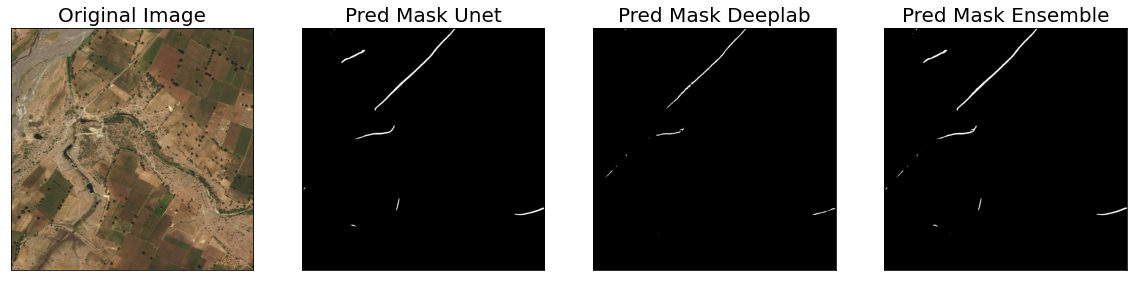

In [ ]:
image_id = 5

image = test_dataset[image_id]
image = preprocess_resize_image(image)


image_vis = cv2.resize(test_dataset_vis[image_id].astype('uint8'), (1536, 1536), interpolation = cv2.INTER_AREA)
x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

pred_mask_unet = best_model_unet(x_tensor)
pred_mask_deepLab = best_model_deepLab(x_tensor)

pred_mask_unet = pred_mask_unet.detach().squeeze().cpu().numpy()
pred_mask_deepLab = pred_mask_deepLab.detach().squeeze().cpu().numpy()

pred_mask_unet = np.transpose(pred_mask_unet,(1,2,0))
pred_mask_deepLab = np.transpose(pred_mask_deepLab,(1,2,0))
pred_mask_ensemble = get_ensemble_maxpool_prediction(pred_mask_unet, pred_mask_deepLab)

pred_mask_unet = colour_code_segmentation(reverse_one_hot(pred_mask_unet), select_class_rgb_values)
pred_mask_deepLab = colour_code_segmentation(reverse_one_hot(pred_mask_deepLab), select_class_rgb_values)
pred_mask_ensemble = colour_code_segmentation(reverse_one_hot(pred_mask_ensemble), select_class_rgb_values)

visualize(
        original_image = image_vis,
        pred_mask_unet = pred_mask_unet,
        pred_mask_deepLab = pred_mask_deepLab,
        pred_mask_ensemble = pred_mask_ensemble
    )

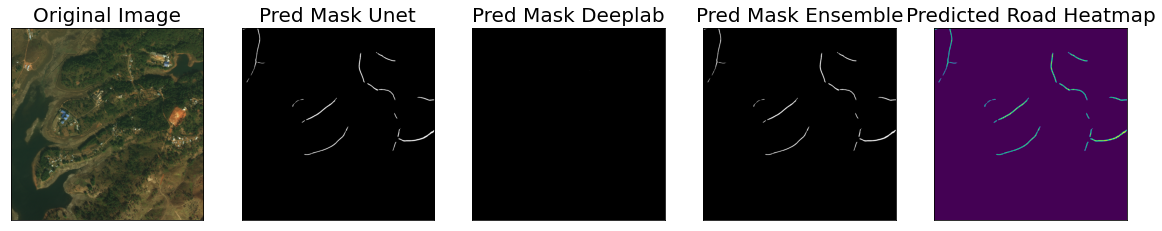

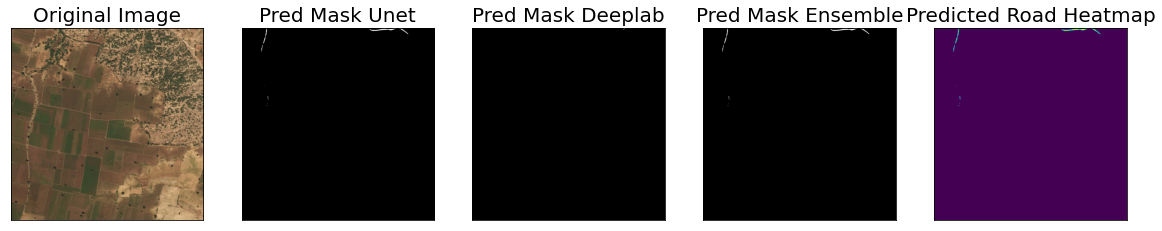

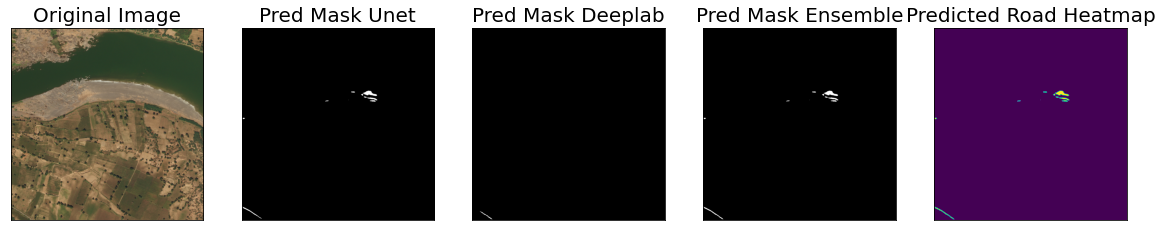

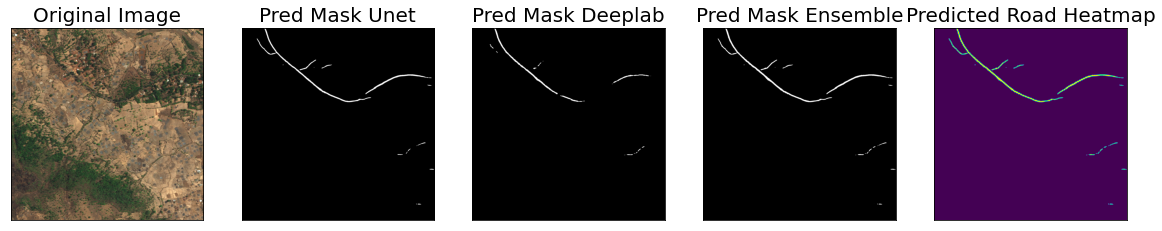

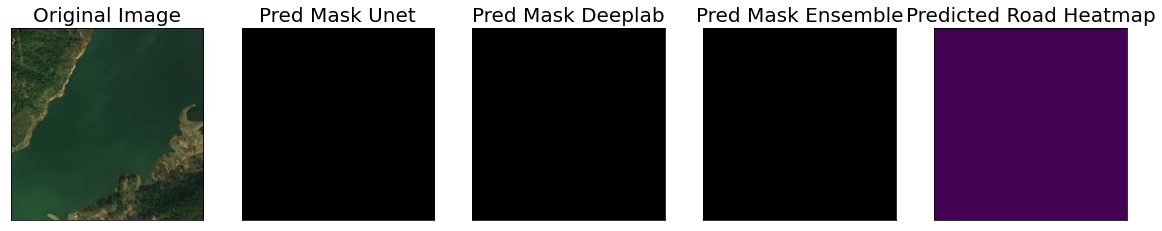

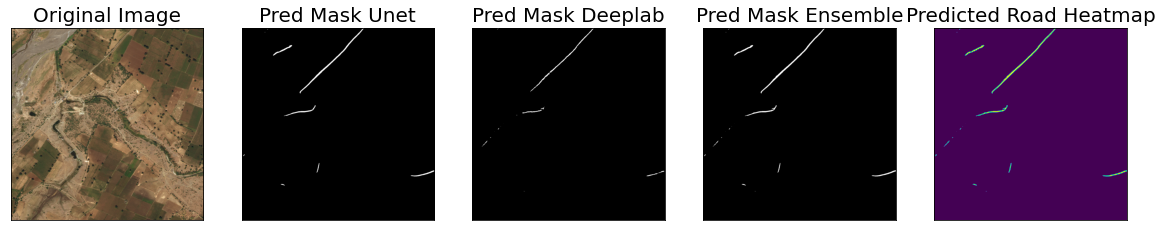

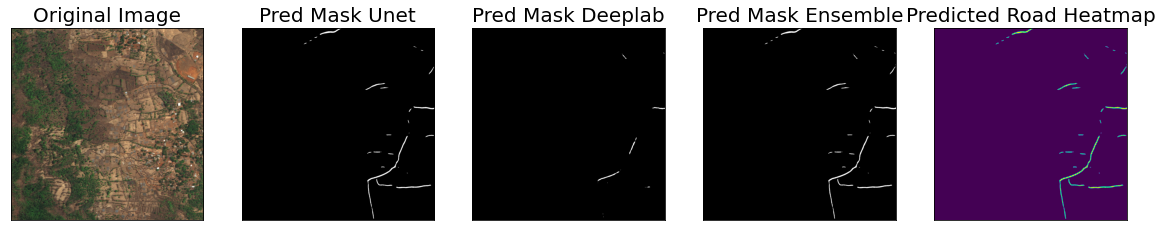

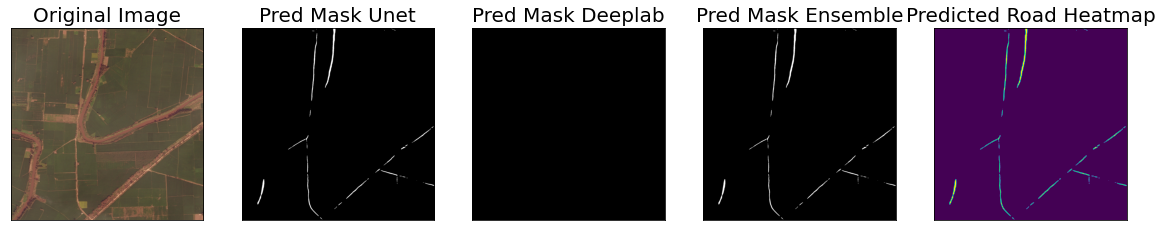

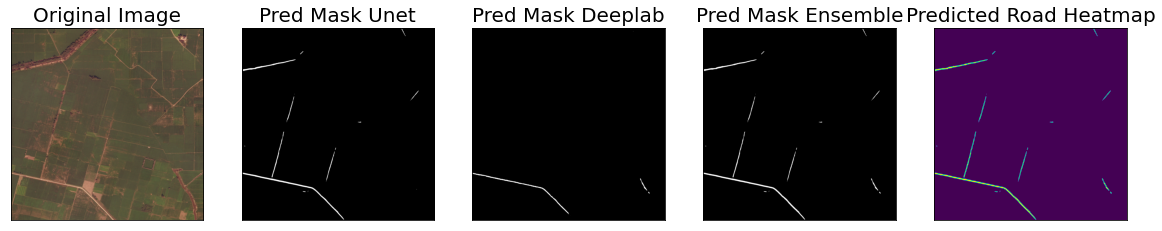

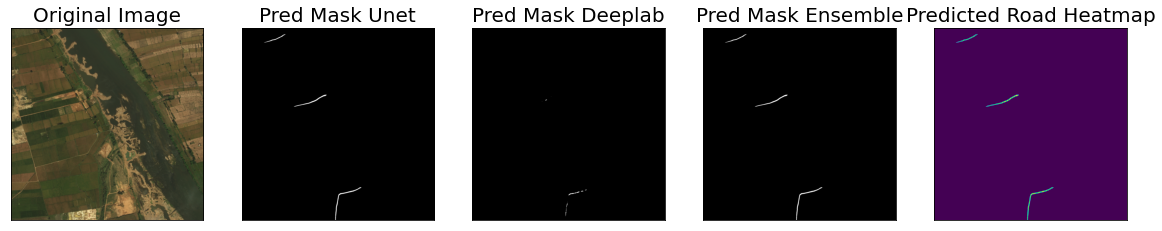

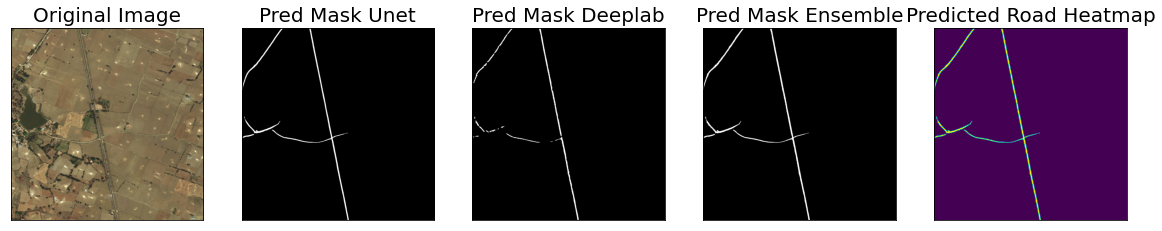

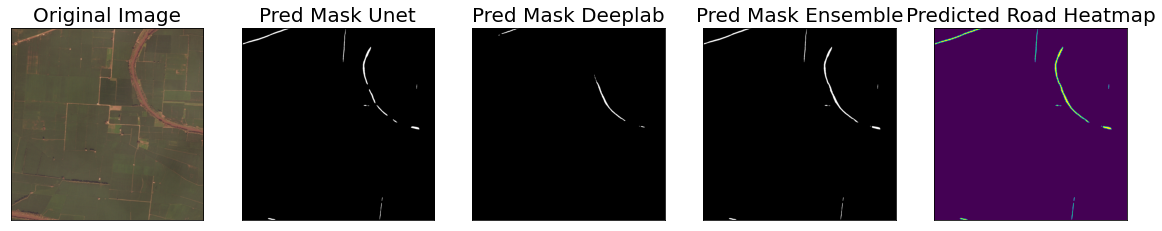

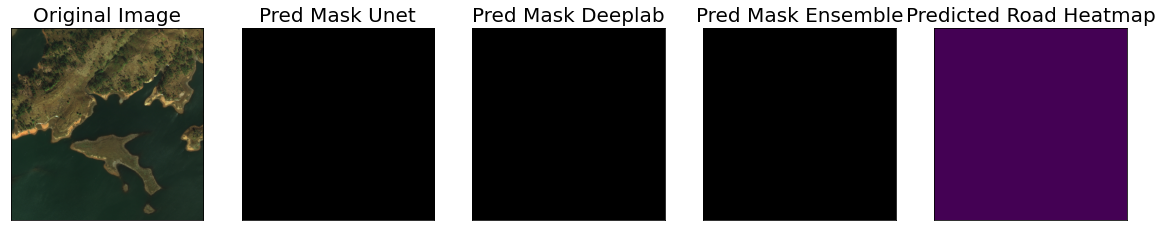

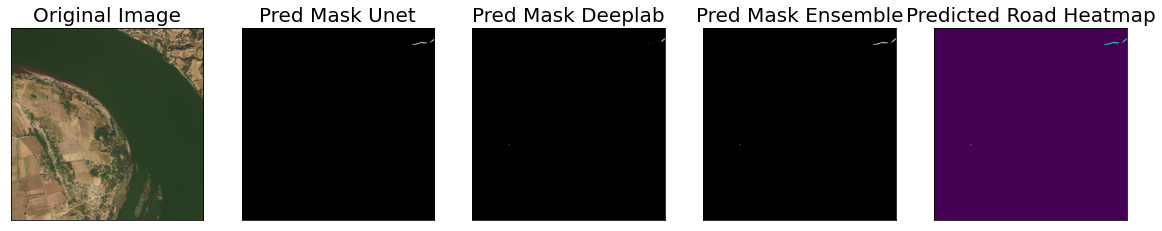

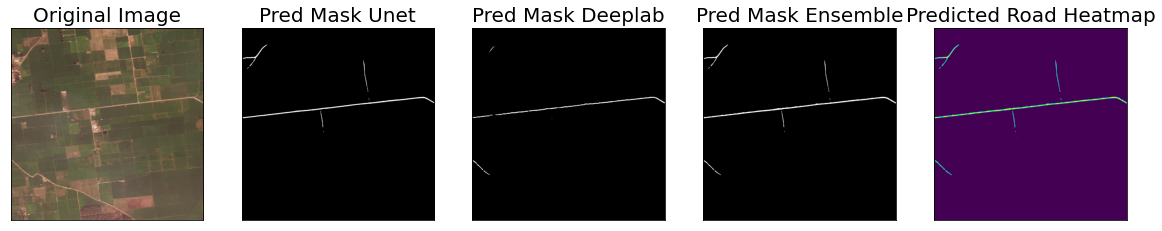

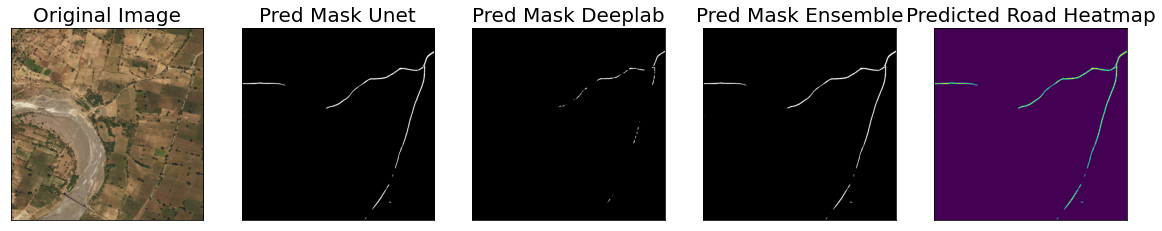

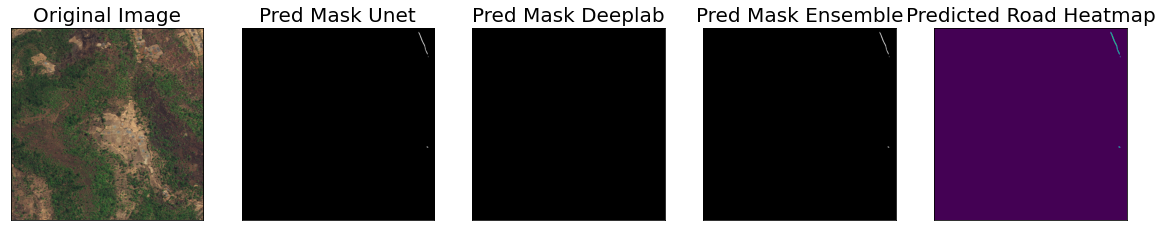

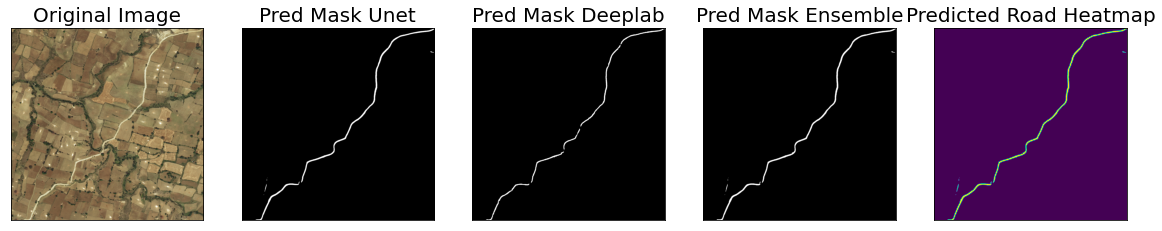

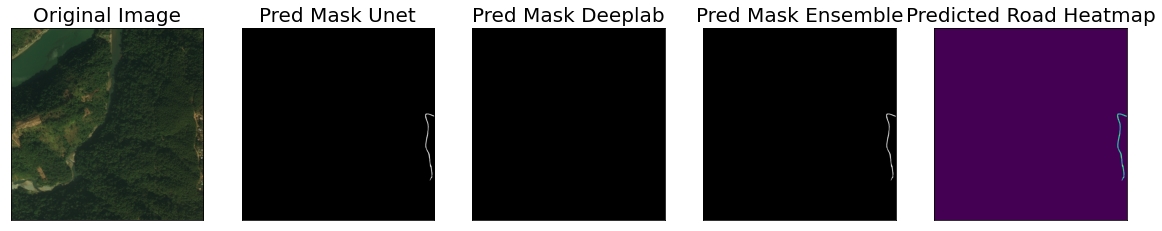

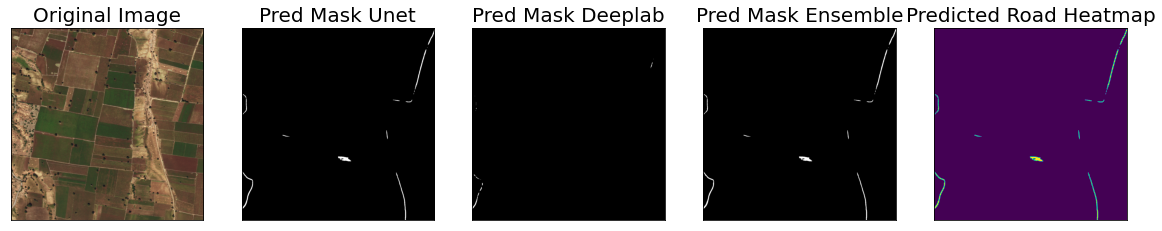

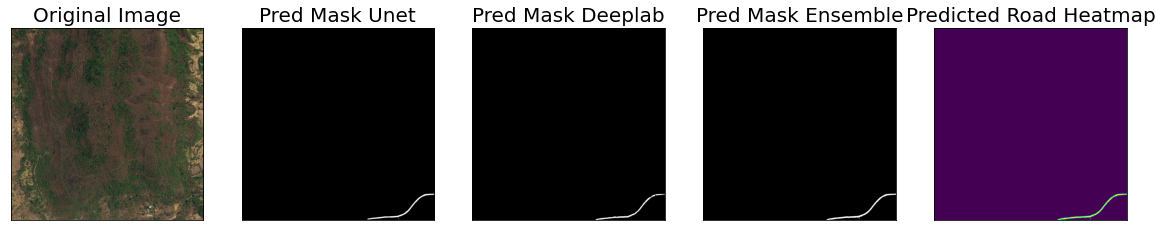

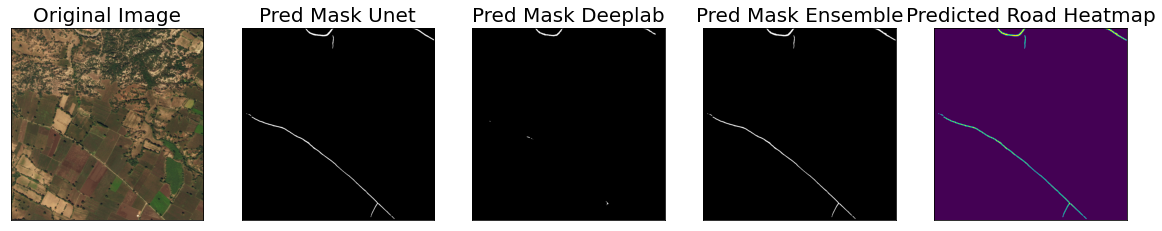

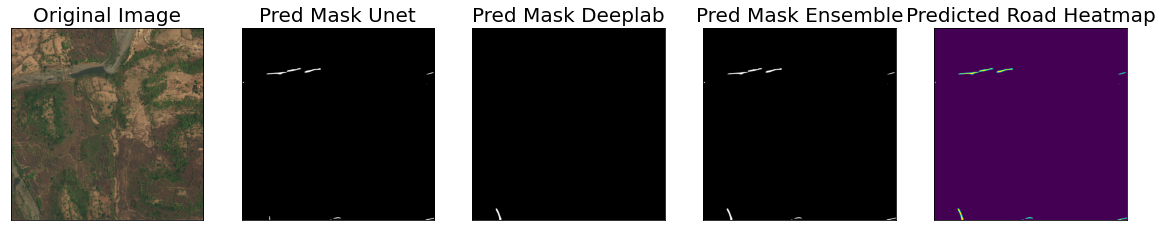

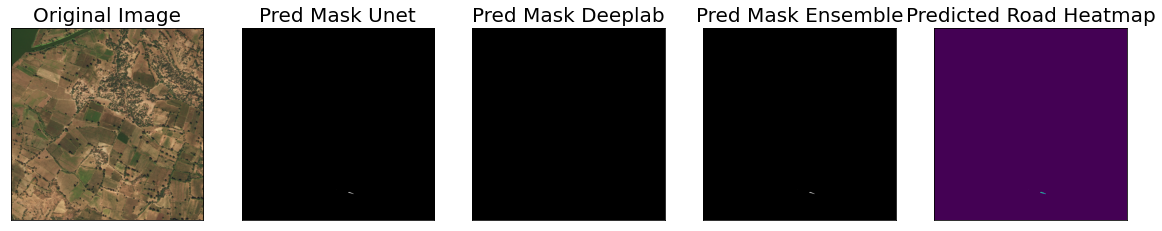

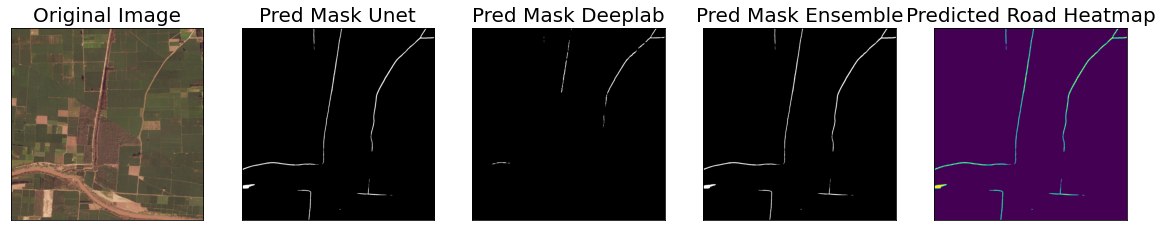

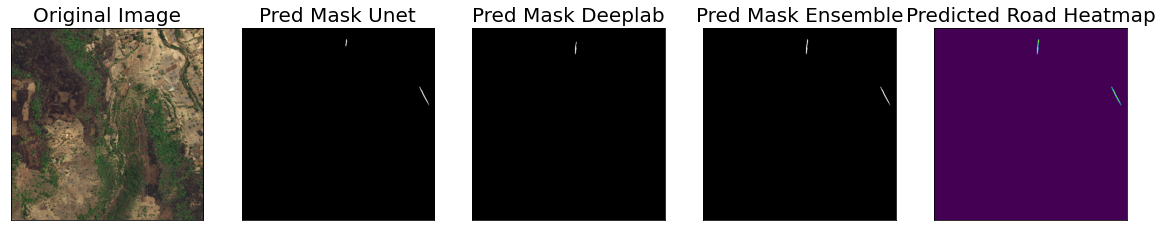

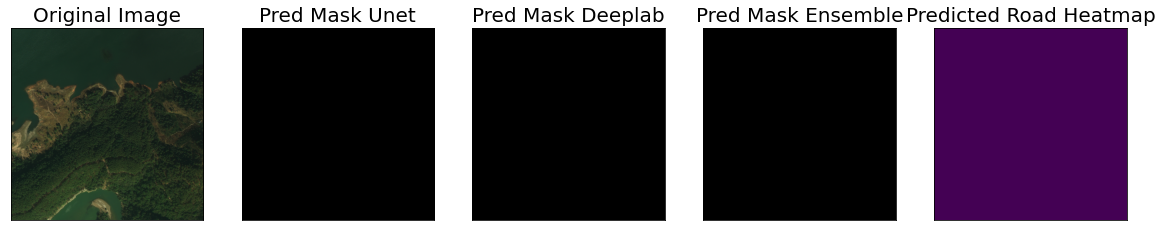

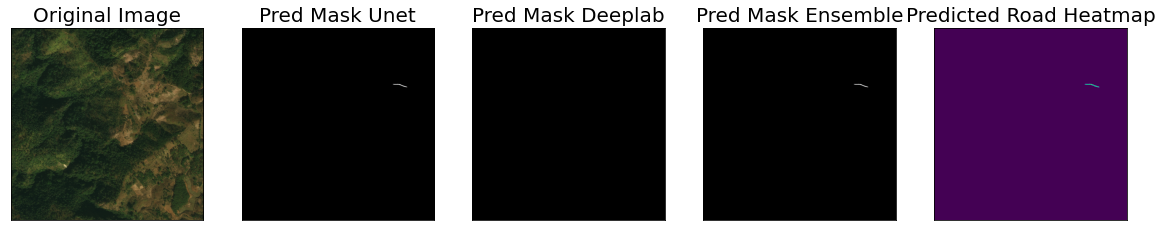

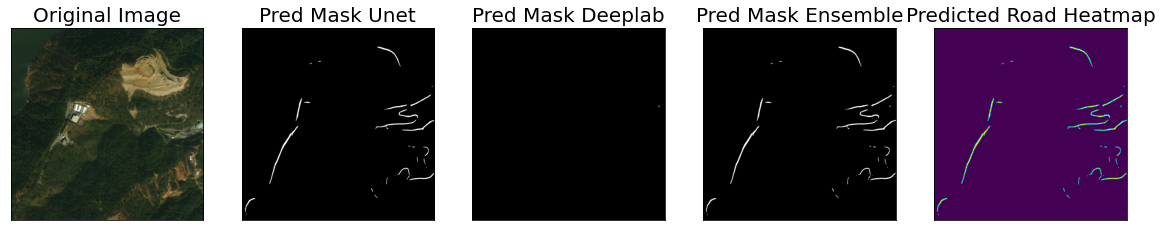

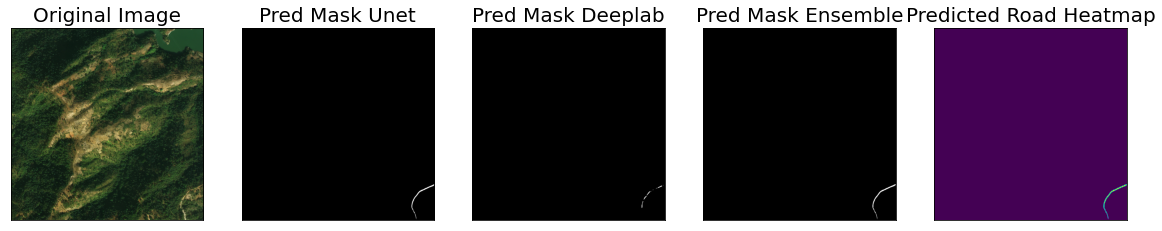

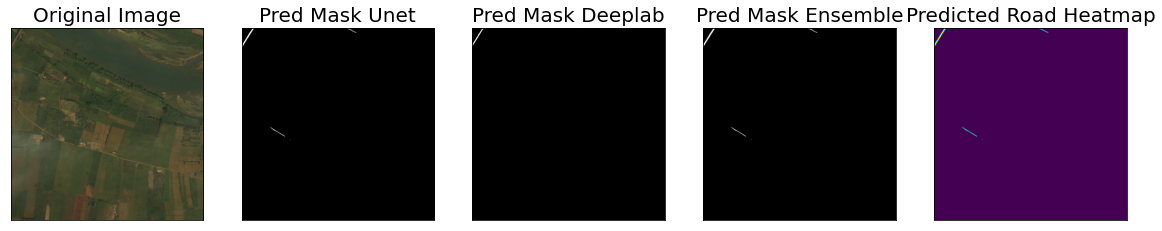

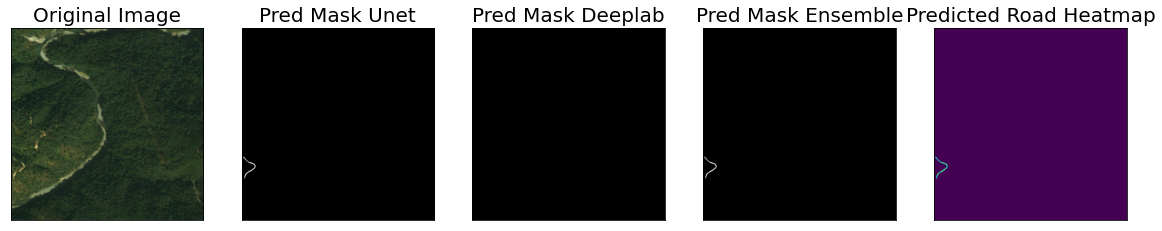

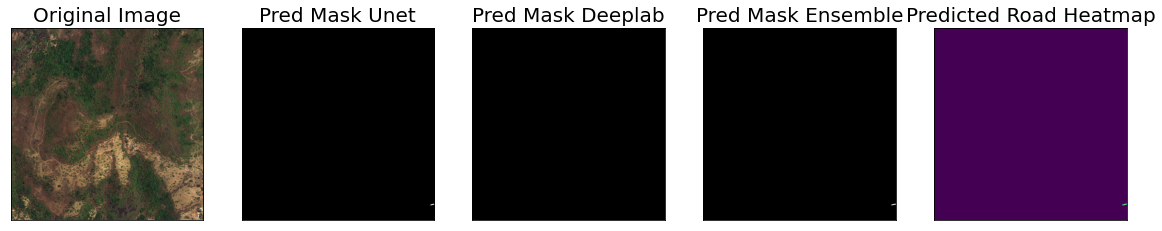

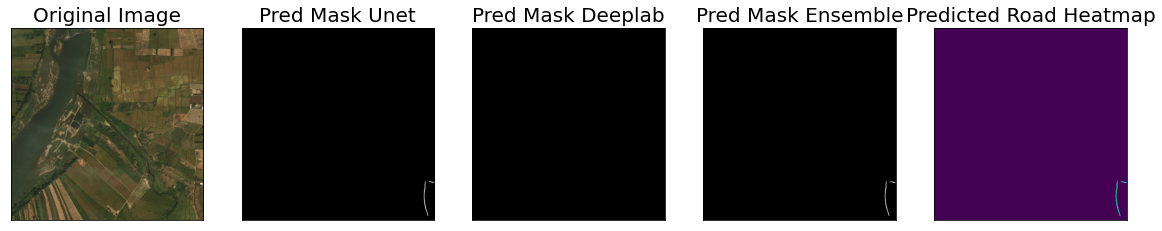

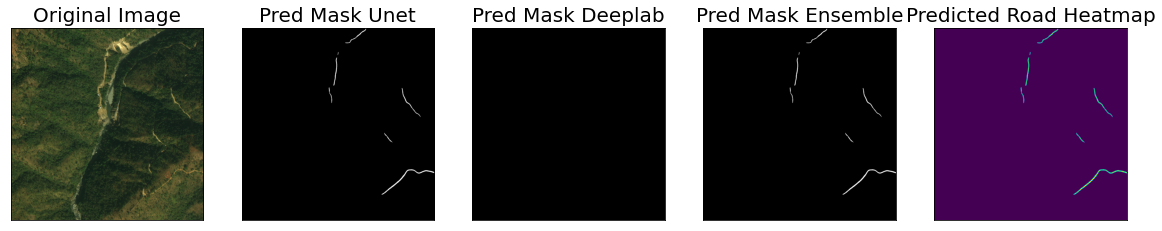

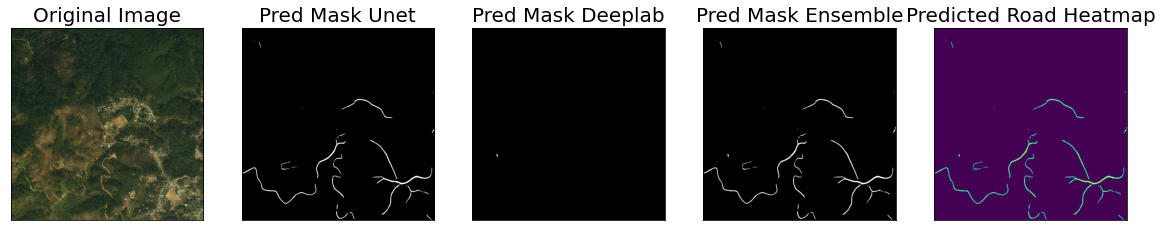

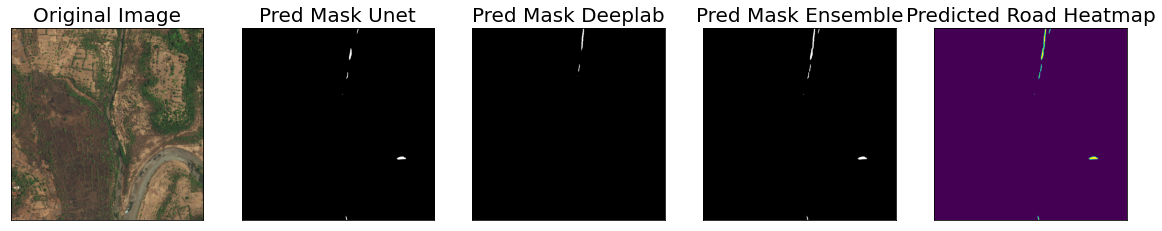

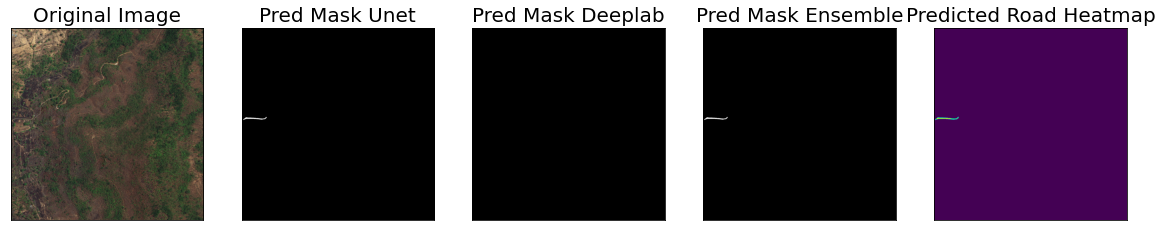

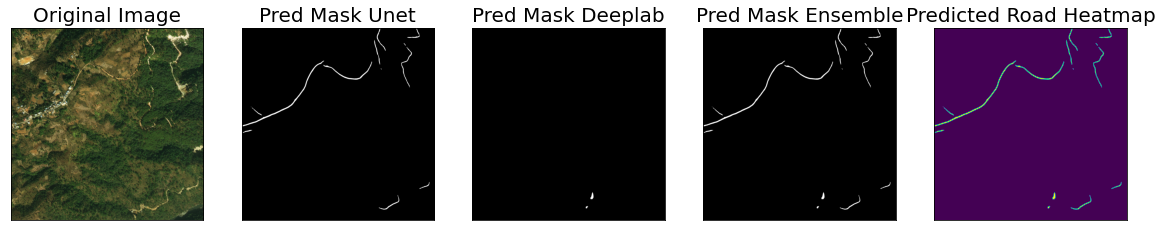

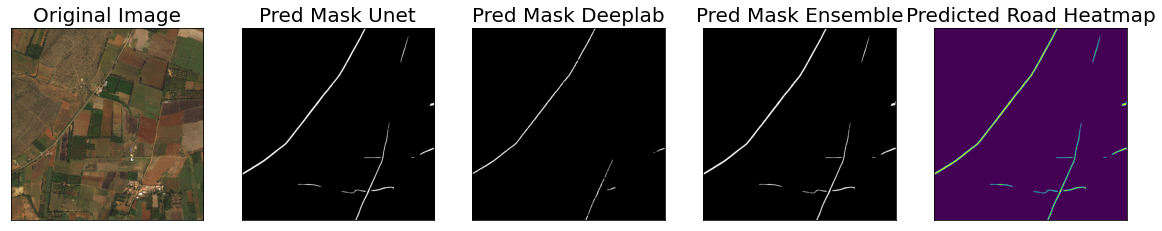

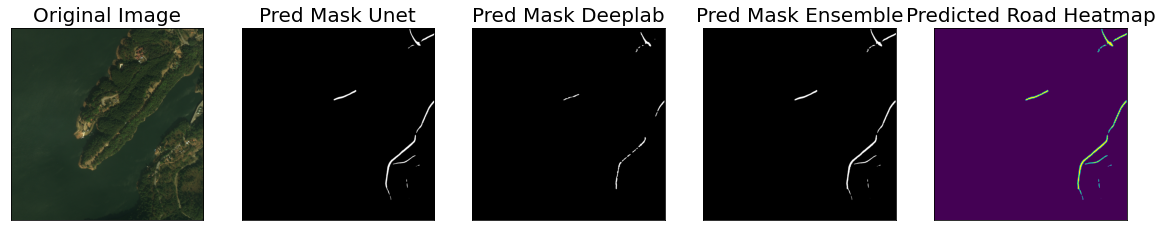

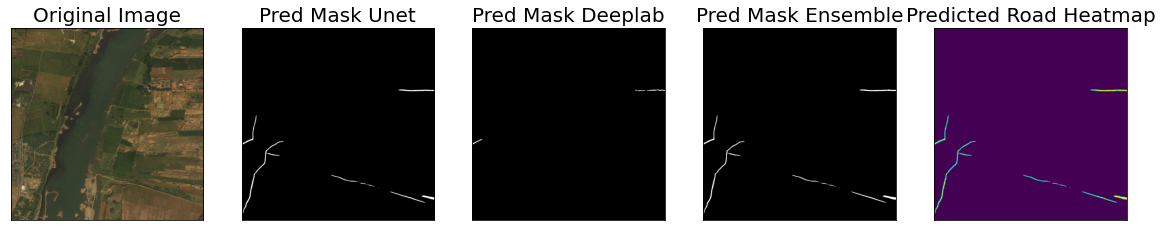

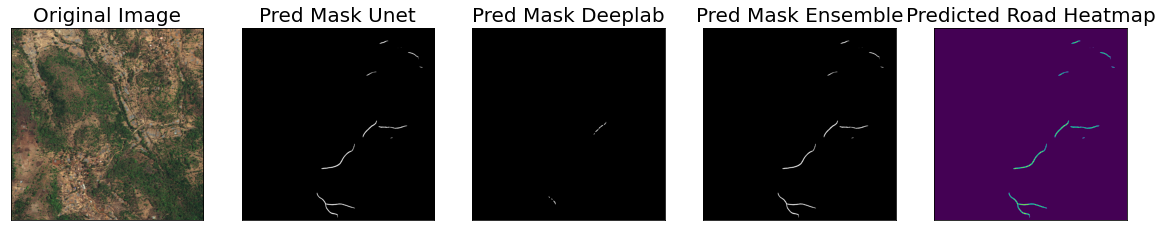

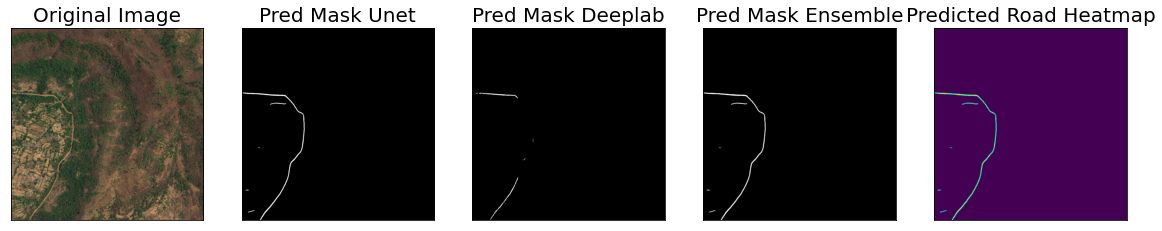

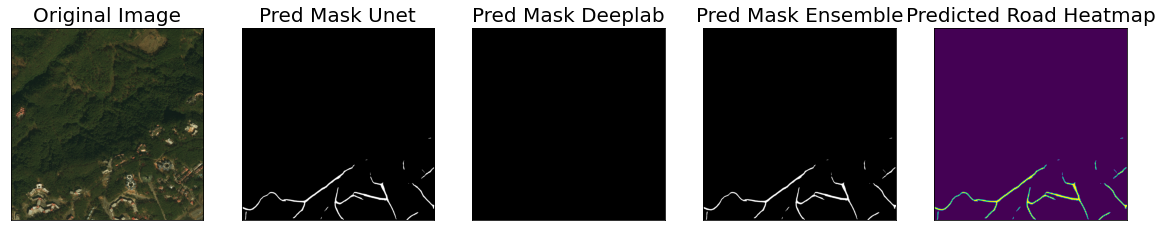

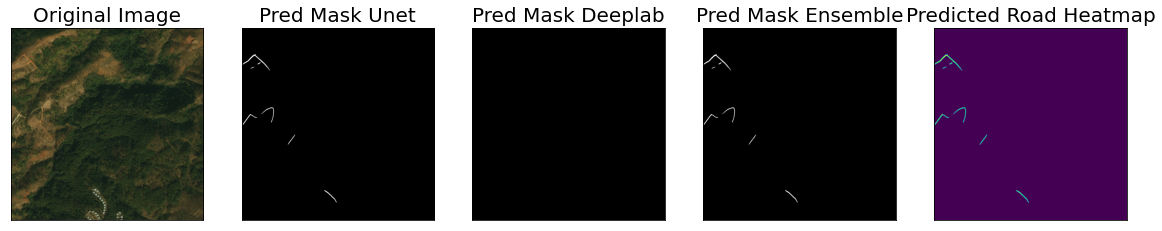

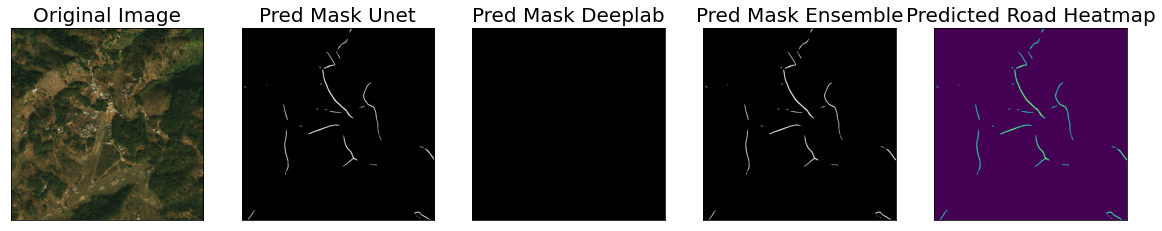

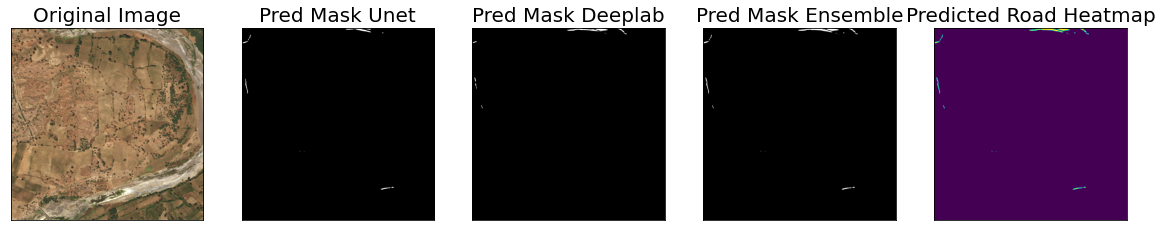

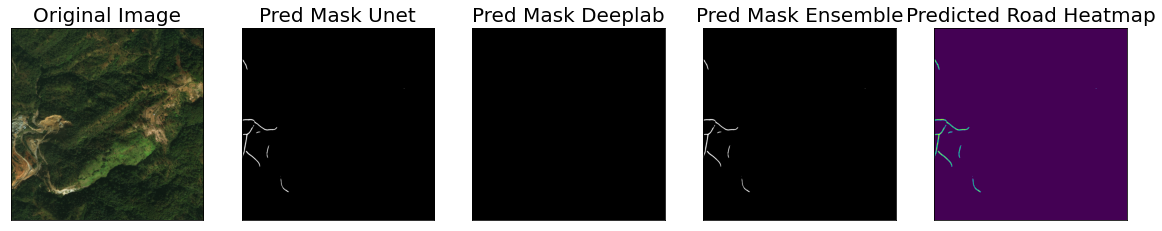

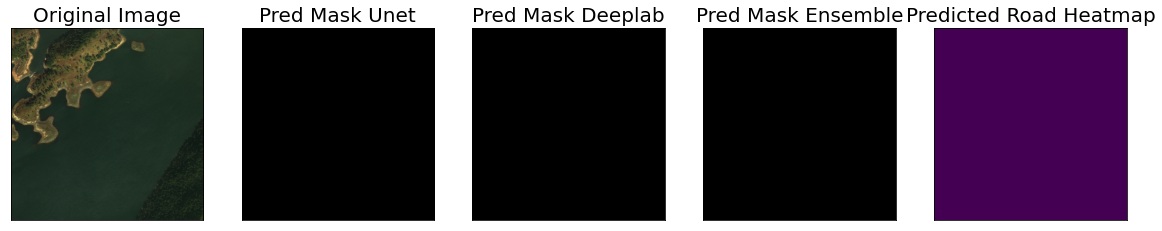

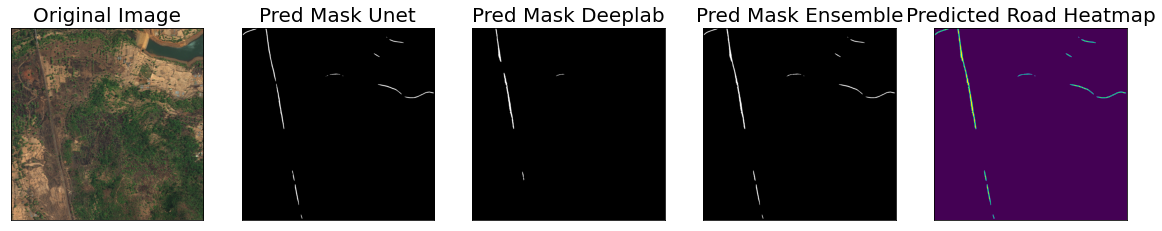

In [ ]:
import pickle

for idx in range(len(test_dataset)):
    
    image = test_dataset[idx]
    image = preprocess_resize_image(image)


    image_vis = cv2.resize(test_dataset_vis[idx].astype('uint8'), (1536, 1536), interpolation = cv2.INTER_AREA)
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

    pred_mask_unet = best_model_unet(x_tensor)
    pred_mask_deepLab = best_model_deepLab(x_tensor)

    pred_mask_unet = pred_mask_unet.detach().squeeze().cpu().numpy()
    pred_mask_deepLab = pred_mask_deepLab.detach().squeeze().cpu().numpy()

    pred_mask_unet = np.transpose(pred_mask_unet,(1,2,0))
    pred_mask_deepLab = np.transpose(pred_mask_deepLab,(1,2,0))
    pred_mask_ensemble = get_ensemble_maxpool_prediction(pred_mask_unet, pred_mask_deepLab)

    pred_mask_unet = colour_code_segmentation(reverse_one_hot(pred_mask_unet), select_class_rgb_values)
    pred_mask_deepLab = colour_code_segmentation(reverse_one_hot(pred_mask_deepLab), select_class_rgb_values)
    pred_mask_ensemble = colour_code_segmentation(reverse_one_hot(pred_mask_ensemble), select_class_rgb_values)


    with open(os.path.join(sample_preds_folder, prediction_matrix, f"sample_pred_{idx}.pkl"), 'wb') as f:
        pickle.dump(pred_mask_ensemble, f)

    # Get prediction channel corresponding to road
    pred_road_heatmap = pred_mask_ensemble[:,:,select_classes.index('road')]
    # pred_road_heatmap = cv2.cvtColor(pred_road_heatmap, cv2.COLOR_BGR2RGB)

    cv2.imwrite(os.path.join(sample_preds_folder, original_image_folder, f"sample_pred_{idx}.png"), cv2.cvtColor(image_vis, cv2.COLOR_RGB2BGR))
    cv2.imwrite(os.path.join(sample_preds_folder, predictions_folder, f"sample_pred_{idx}.png"), pred_mask_ensemble)

    visualize(
        original_image = image_vis,
        pred_mask_unet = pred_mask_unet,
        pred_mask_deepLab = pred_mask_deepLab,
        pred_mask_ensemble = pred_mask_ensemble,
        predicted_road_heatmap = pred_road_heatmap
    )